In [1]:
pwd

'/gpfs/space/home/pyvovar/repos/ADL-Minicar-Challenge-2023/mycar/notebooks'

In [2]:
!ls ../data/

pedestrian_new	steering_night	stop_sign_dataset
steering	stop_sign	zebra_dataset


In [2]:
import os
from os.path import join
import shutil
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.2.0


In [3]:
!which python

/gpfs/space/software/jupyterhub/python/jupyter/bin/python


# Prepare Car Dataset

In [4]:
data_path = "../data"
data_path_steering = os.path.join(data_path, "steering")
data_path_car = os.path.join(data_path, "car_dataset")

In [16]:
ls {data_path}

car_dataset/     steering/        stop_sign/          zebra_dataset/
pedestrian_new/  steering_night/  stop_sign_dataset/


In [17]:
label_with = 1
label_without = 0

In [18]:
ls {data_path_steering}

tub_3_22-10-25/  tub_5_22-10-27/  tub_7_22-11-01/
tub_4_22-10-25/  tub_6_22-11-01/  tub_8_22-11-03/


In [19]:
steering_images = []
for thing in os.listdir(data_path_steering):
    if thing.startswith("tub") and not thing.startswith("tub_3"):
        tub_path = join(data_path_steering, thing, "images")
        for img in os.listdir(tub_path):
            steering_images.append(join(tub_path, img))

In [20]:
len(steering_images)

62463

In [21]:
steering_images[:10]

['../data/steering/tub_4_22-10-25/images/4790_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/2488_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/14077_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/7364_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/317_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/13208_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/1844_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/11363_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/13379_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/253_cam_image_array_.jpg']

In [22]:
random.seed(2022)
images = random.sample(steering_images, k=1000)

In [23]:
images[:10]

['../data/steering/tub_6_22-11-01/images/10981_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/3353_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/3091_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/7588_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/3245_cam_image_array_.jpg',
 '../data/steering/tub_5_22-10-27/images/5239_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/1665_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/3406_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/12972_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/12471_cam_image_array_.jpg']

In [24]:
ls {data_path_car}

with/  without/


In [25]:
for img in os.listdir(join(data_path_car, "without")):
    images.append(join(data_path_car, "without", img))

In [26]:
images[-10:]

['../data/car_dataset/without/1105_cam_image_array_.jpg',
 '../data/car_dataset/without/1476_cam_image_array_.jpg',
 '../data/car_dataset/without/1780_cam_image_array_.jpg',
 '../data/car_dataset/without/1337_cam_image_array_.jpg',
 '../data/car_dataset/without/139_cam_image_array_.jpg',
 '../data/car_dataset/without/366_cam_image_array_.jpg',
 '../data/car_dataset/without/993_cam_image_array_.jpg',
 '../data/car_dataset/without/797_cam_image_array_.jpg',
 '../data/car_dataset/without/1141_cam_image_array_.jpg',
 '../data/car_dataset/without/1350_cam_image_array_.jpg']

In [27]:
len(images)

3002

In [28]:
labels = [label_without] * len(images)

In [29]:
labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
# Collect paths of images WITH a stop sign
for img in os.listdir(join(data_path_car, "with")):
    images.append(join(data_path_car, "with", img))

In [31]:
len(images)

6086

In [140]:
images[-10:]

['../data/car_dataset/with/1873_cam_image_array_.jpg',
 '../data/car_dataset/with/2444_cam_image_array_.jpg',
 '../data/car_dataset/with/153_cam_image_array_.jpg',
 '../data/car_dataset/with/739_cam_image_array_.jpg',
 '../data/car_dataset/with/2059_cam_image_array_.jpg',
 '../data/car_dataset/with/2257_cam_image_array_.jpg',
 '../data/car_dataset/with/740_cam_image_array_.jpg',
 '../data/car_dataset/with/537_cam_image_array_.jpg',
 '../data/car_dataset/with/54_cam_image_array_.jpg',
 '../data/car_dataset/with/2020_cam_image_array_.jpg']

In [32]:
ls ../data/car_dataset/with/ | wc -l

3084


In [33]:
labels += [label_with] * 3084

In [34]:
corrupt_images = []
for i, img in enumerate(images):
    if cv2.imread(img) is None:
        corrupt_images.append(img)
        print(images[i])
        print(images.pop(i))
        print(labels.pop(i))
        print()

# Prepare Input Data Pipeline

In [36]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=2022)

In [37]:
mean = [0.4251, 0.4787, 0.4311]  # calculated in the separate notebook
std = [0.2203, 0.2276, 0.2366]  # calculated in the separate notebook


def apply_normalization(cv_image_rgb_uint8):
    image = np.float32(cv_image_rgb_uint8) / 255.0
    image -= mean
    image /= std
    return image


def reverse_normalization(cv_image_rgb_float32):
    image = cv_image_rgb_float32 * std
    image += mean
    image *= 255
    image = image.astype(np.uint8)
    return image

40


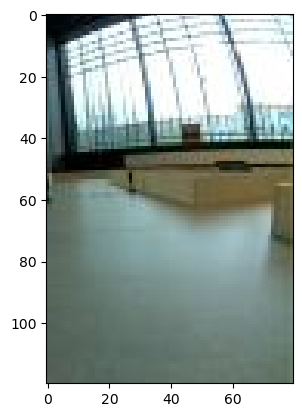

In [46]:
img = cv2.imread(images[1000])

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cropped = img.copy()
cropped = cropped[:, cropped.shape[1]//2:, :]
print(cropped.shape[1]//2)
plt.imshow(cropped)

In [47]:
def transforms(cv_image_rgb):
    cv_image_rgb = cv_image_rgb[:, cv_image_rgb.shape[1]//2:, :]
    return apply_normalization(cv_image_rgb)


def load_image(image_path):
    image_bgr = cv2.imread(image_path.numpy().decode("utf-8"))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = transforms(image_rgb)
    return tf.convert_to_tensor(image_rgb)


def preprocess_labels(label):
    return tf.expand_dims(tf.cast(label, "float32"), axis=-1)


def configure_dataset(ds):
    # Keep the images in memory after they're loaded off disk during the first epoch
    ds = ds.cache()
    # Drop elements that cause errors
    ds = ds.apply(tf.data.experimental.ignore_errors())
    # Wrap the 'load_image' call inside 'tf.py_function' due to https://github.com/tensorflow/tensorflow/issues/30653
    ds = ds.map(lambda image_path, label: (
        tf.py_function(load_image, [image_path], tf.float32),
        tf.py_function(preprocess_labels, [label], np.float32)
    ), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Create batches
    ds = ds.batch(64)
    # prepare later elements while the current element is being processed
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = configure_dataset(ds_train)
ds_val = configure_dataset(ds_val)
ds_test = configure_dataset(ds_test)

2022-12-07 11:48:56.718603: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(64, 120, 80, 3)
(64, 1)


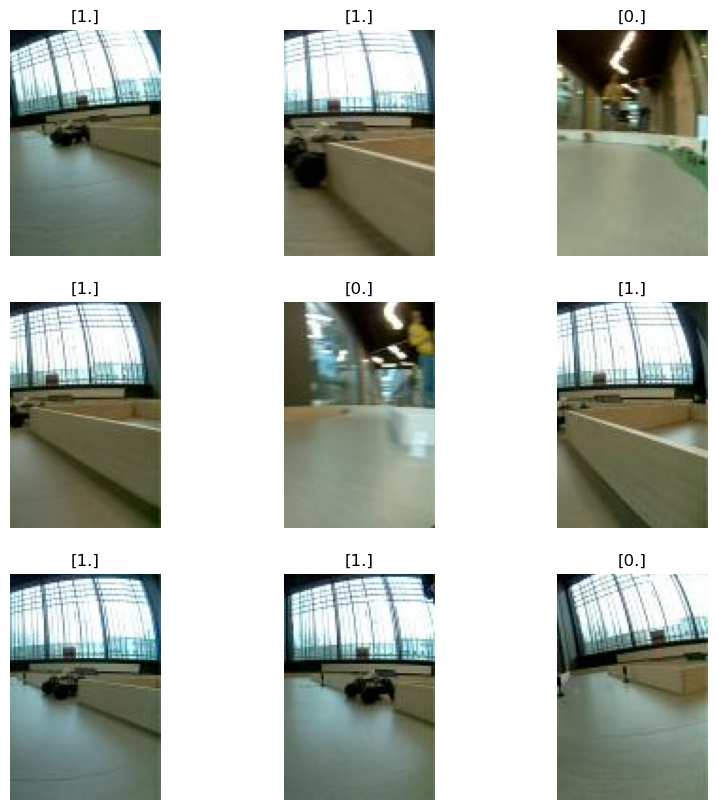

In [48]:
image_batch, label_batch = next(iter(ds_train))
print(image_batch.shape)
print(label_batch.shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(reverse_normalization(image_batch[-i].numpy()))
    # plt.imshow((image_batch[-i].numpy() * 255).astype(np.uint8))
    plt.title(label_batch[-i].numpy())
    plt.axis("off")

# Define and Train the Model

In [49]:
# TODO Cropping
# TODO Augmentation
# TODO add dropout and batch norm
# TODO K-Fold Cross-Validation for hyperparameters

model = tf.keras.Sequential([
    InputLayer(input_shape=(120, 80, 3)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

n_epochs = 5
log_frequency = 50
threshold = 0.5

optimizer = Adam(learning_rate=0.0001)
criterion = tf.keras.losses.BinaryCrossentropy()

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(n_epochs):
    # Training
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = model(image_batch, training=True)
            loss_value = criterion(label_batch, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        train_loss_history.append(current_loss)
        train_accuracy_history.append(current_accuracy)

        running_loss += current_loss
        running_accuracy += current_accuracy
        if (step + 1) % log_frequency == 0:
            print(
                f'Train [{epoch + 1}/{n_epochs}, {step + 1}/?]: Loss {running_loss / log_frequency}, Accuracy {running_accuracy / log_frequency}')
            running_loss = 0.0
            running_accuracy = 0.0

    # Validation
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_val):
        logits = model(image_batch, training=False)
        loss_value = criterion(label_batch, logits)

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        val_loss_history.append(current_loss)
        val_accuracy_history.append(current_accuracy)

        running_loss += current_loss
        running_accuracy += current_accuracy
        if (step + 1) % log_frequency == 0:
            print(
                f'Val [{epoch + 1}/{n_epochs}, {step + 1}/?]: Loss {running_loss / log_frequency}, Accuracy {running_accuracy / log_frequency}')
            running_loss = 0.0
            running_accuracy = 0.0

Train [1/5, 50/?]: Loss 0.5382602566480637, Accuracy 0.7234375
Train [2/5, 50/?]: Loss 0.23613853216171266, Accuracy 0.941875
Train [3/5, 50/?]: Loss 0.09188120402395725, Accuracy 0.98
Train [4/5, 50/?]: Loss 0.04983747251331806, Accuracy 0.990625
Train [5/5, 50/?]: Loss 0.030169354025274514, Accuracy 0.995


Text(0.5, 1.0, 'Accuracy')

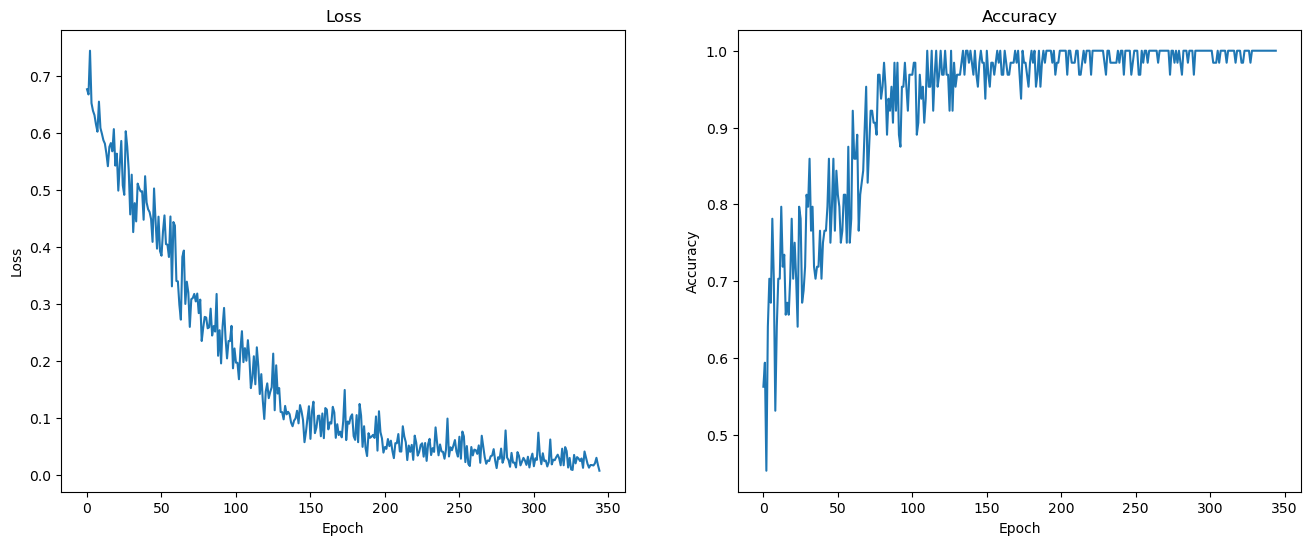

In [50]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
#plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history)
#plt.plot(val_accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [51]:
# TODO add confusion matrix and choose a threshold using AUC
# Testing
threshold = 0.5

test_loss = 0.0
test_accuracy = 0.0
batches = 0
for step, (image_batch, label_batch) in enumerate(ds_test):
    logits = model(image_batch, training=False)
    loss_value = criterion(label_batch, logits)

    # Metrics and Logging
    current_loss = loss_value.numpy()
    current_accuracy = accuracy_score(label_batch, logits > threshold)

    test_loss += current_loss
    test_accuracy += current_accuracy
    batches += 1

test_loss /= batches
test_accuracy /= batches

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.022758652362972497
Test Accuracy: 0.99375


In [52]:
model.save("../models/car_detector_v2")

2022-12-07 11:55:47.561828: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/car_detector_v2/assets
